# TF-IDF

### Imports

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch
import pandas as pd
import time

### Helper Functions

In [21]:
def plot_TF_IDF_results (dfResults, val_opt, fixed_param, var_param) :
    """
    Plot TF-IDF hyperparameter search results

    params :
        dfResults : pandas dataframe containing the results of the hyperparameter search
        val_opt : optimal value for either max_df or min_df
        fixed_param : string indicating which of min_df or max_df is the fixed parameter 
                      for which we're doing the plots
        var_param : string indicating which of min_df or max_df is the variable parameter 
                    for which we're doing the plots
    """
    

    # Collect results corresponding to val_opt
    dfResults_trunc = dfResults[dfResults[fixed_param] == val_opt].copy()

    # Extract unique values corresponding to the string fixed param
    vals = dfResults_trunc[var_param].unique()

    # Plotting
    for val in vals:

        # Filter results for the specified parameter
        lambda_values = (dfResults_trunc[dfResults_trunc[var_param] == val])['Lambda'].copy().values
        accuracy_values = (dfResults_trunc[dfResults_trunc[var_param] == val])['Accuracy'].copy().values

        indices = np.argsort(lambda_values)
        lambda_values = lambda_values[indices]
        accuracy_values = accuracy_values[indices]

        # Plotting for each variable parameter value
        plt.plot(lambda_values, accuracy_values, linewidth = 1 , marker='o', linestyle='-', label=f"{var_param} = {val}")

    # Plot details
    plt.title(f'Accuracy vs Lambda for {fixed_param} = {val_opt}')
    plt.xlabel('Lambda')
    plt.xscale('log')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def loadTrainTweets(positive_file_path, negative_file_path):
    # Read the file and split lines on "\n"
    with open(positive_file_path, 'r', encoding='utf-8') as file:
        lines_pos = file.read().split('\n')

    # Read the file and split lines on "\n"
    with open(negative_file_path, 'r', encoding='utf-8') as file:
        lines_neg = file.read().split('\n')

    # Create a DataFrame with a single column 'tweets'
    df_pos = pd.DataFrame({'tweets': lines_pos})
    df_pos['labels'] = 1

    df_neg = pd.DataFrame({'tweets': lines_neg})
    df_neg['labels'] = 0

    df = pd.concat([df_pos, df_neg], ignore_index=True)

    df = df.sample(frac=1).reset_index(drop=True)

    return df

### Load Raw Text Data into pandas dataframes

In [19]:
positive_file_path = 'data/train_pos_full.txt'
negative_file_path = 'data/train_neg_full.txt'
positive_file_path_small = 'data/train_pos.txt'
negative_file_path_small = 'data/train_neg.txt'

# Load  (Full and Small datasets)
df = loadTrainTweets(positive_file_path, negative_file_path)
df_small = loadTrainTweets(positive_file_path_small, negative_file_path_small)

### Hyperparameter search over Lambda (regularization strength, max_df and min_df), small tweet datasets have benn used for faster computation.

In [ ]:
# Regularization Strength for logistic regression
lambdas = [1e-3, 1e-2, 1e-1, 1, 10]

# Ignore tokens that have a document frequency strictly higher than 
# max_df (corpus-specific stop words)
max_dfs = [0.5, 0.7, 0.8, 1.0]

# Ignore terms that have a document frequency strictly lower than the given threshold.
# This value is also called cut-off in the literature
min_dfs = [1, 2, 3, 5]

# Number of Folds For Cross-Validation
skf = KFold(n_splits=5, shuffle=True, random_state=17)

# Initialization of accuracy 
acc_best = 0

# Array containing different accuracies, lambdas, max_dfs and min_dfs
results = []

with warnings.catch_warnings():
    for lambda_ in lambdas :
        for max_df in max_dfs :
            for min_df in min_dfs :
                warnings.filterwarnings("ignore", category=ConvergenceWarning)

                print("Lambda : ", lambda_)
                print("max_df : ", max_df)
                print("min_df : ", min_df)

                # Initialoize TF-IDF Encoder
                text_transformer = TfidfVectorizer(stop_words=None, 
                                                    ngram_range=(1,2),
                                                    max_df=max_df,
                                                    min_df= min_df, 
                                                    lowercase=True)
                
                # Encode the dataset using TF-IDF
                X_train_cross = text_transformer.fit_transform(df_small['tweets'])

                # Initialize Logistic Regression model
                logit = LogisticRegression(C = 1/lambda_, solver='lbfgs')

                # Classify the training data using cross-validation
                predicted_labels = cross_val_predict(logit, X_train_cross, df_small['labels'], cv=skf)

                # Compute the accuracy score
                acc = accuracy_score(df_small['labels'], predicted_labels)

                print("Accuracy: ", acc)
                print("--------------------------------------------")

                result = {
                    "Lambda": lambda_,
                    "Accuracy": acc,
                    "max_df": max_df,
                    "min_df": min_df
                }

                if acc > acc_best:
                    acc_best = acc
                    lambda_best = lambda_
                    max_df_best = max_df
                    min_df_best = min_df

                results.append(result)


print("------------------------------------------------------------------------")
print("--------------------------------------------")

print("BEST RESULT: ", "Accuracy : ", acc_best,
                       "lambda: ", lambda_best,
                       "max_df : ", max_df,
                       "min_df", min_df)

results.sort(key=lambda x: x["Accuracy"], reverse=True)

print("Top 10 Results with the Highest Accuracy:")
print("--------------------------------------------")
for i, result in enumerate(results[:10]):
    print(f"Rank {i + 1}:")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Lambda: {result['Lambda']}")
    print(f"max_df: {result['max_df']}")
    print(f"min_df: {result['min_df']}")
    
    print("--------------------------------------------")

# Save Results into a pandas dataframe in order to create plots
# for hyperparameter search
dfResults = pd.DataFrame(results)

Lambda :  0.001
max_df :  0.5
min_df :  1
Accuracy:  0.8206517934820652
--------------------------------------------
Lambda :  0.001
max_df :  0.5
min_df :  2
Accuracy:  0.8091669083309166
--------------------------------------------
Lambda :  0.001
max_df :  0.5
min_df :  3
Accuracy:  0.8086469135308647
--------------------------------------------
Lambda :  0.001
max_df :  0.5
min_df :  5
Accuracy:  0.7982120178798212
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  1
Accuracy:  0.8194918050819492
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  2
Accuracy:  0.8117018829811702
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  3
Accuracy:  0.8113218867811322
--------------------------------------------
Lambda :  0.001
max_df :  0.7
min_df :  5
Accuracy:  0.8128068719312807
--------------------------------------------
Lambda :  0.001
max_df :  0.8
min_df :  1
Accuracy:  0.819491805

### Read Results from Hyperparameter search and Set optimal max_df and min_df values

In [ ]:
max_dfOpt = 0.5
min_dfOpt = 1

### Plot Accuracy vs Lambda for the optimal max_df value and different min_df values

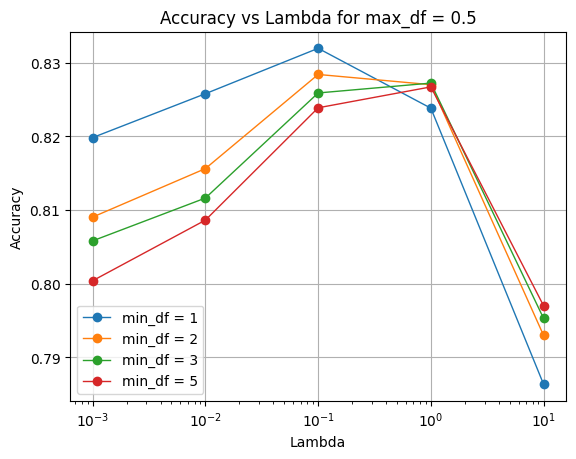

In [ ]:
plot_TF_IDF_results(dfResults, max_dfOpt, fixed_param = 'max_df', var_param = 'min_df')

### Plot Accuracy vs Lambda for the optimal min_df value and different max_df values

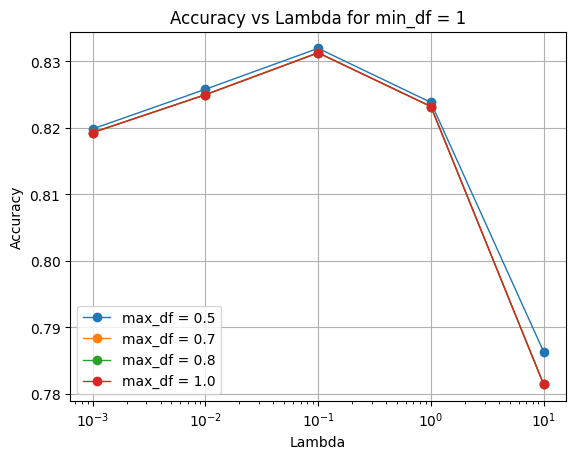

In [ ]:
plot_TF_IDF_results(dfResults, min_dfOpt, fixed_param = 'min_df', var_param = 'max_df')